# Análisis de Clustering: Segmentación de Clientes

## 1. Importar Librerías

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples

import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 2. Carga y Exploración del Dataset

In [5]:
# Cargar datos
df = pd.read_csv('../data/Mall_Customers.csv')

# Primeras filas
print("=== PRIMERAS 5 FILAS ===")
display(df.head())

# Información general
print("\n=== INFORMACIÓN DEL DATASET ===")
print(df.info())

# Estadísticas descriptivas
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
display(df.describe())


# Verificar Valores Nulos y Duplicados
# Valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

# Duplicados
print(f"\nFilas duplicadas: {df.duplicated().sum()}")

# Distribución de género
print("\nDistribución de género:")
print(df['Gender'].value_counts())

=== PRIMERAS 5 FILAS ===


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



=== INFORMACIÓN DEL DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

=== ESTADÍSTICAS DESCRIPTIVAS ===


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Valores nulos por columna:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Filas duplicadas: 0

Distribución de género:
Gender
Female    112
Male       88
Name: count, dtype: int64


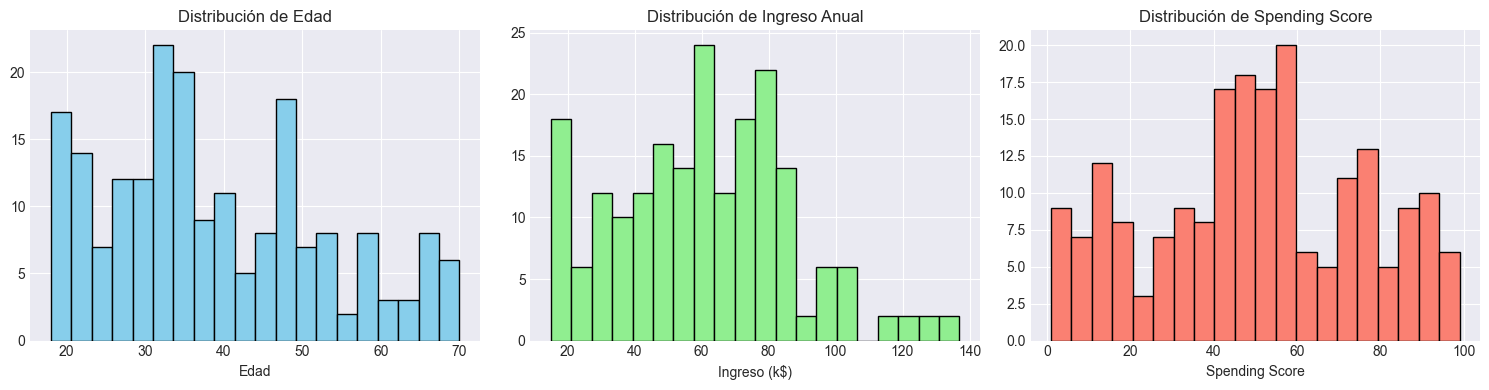

In [6]:
# Visualización exploratoria: Distribuciones de variables numéricas
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['Age'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de Edad')
axes[0].set_xlabel('Edad')

axes[1].hist(df['Annual Income (k$)'], bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribución de Ingreso Anual')
axes[1].set_xlabel('Ingreso (k$)')

axes[2].hist(df['Spending Score (1-100)'], bins=20, color='salmon', edgecolor='black')
axes[2].set_title('Distribución de Spending Score')
axes[2].set_xlabel('Spending Score')

plt.tight_layout()
plt.show()

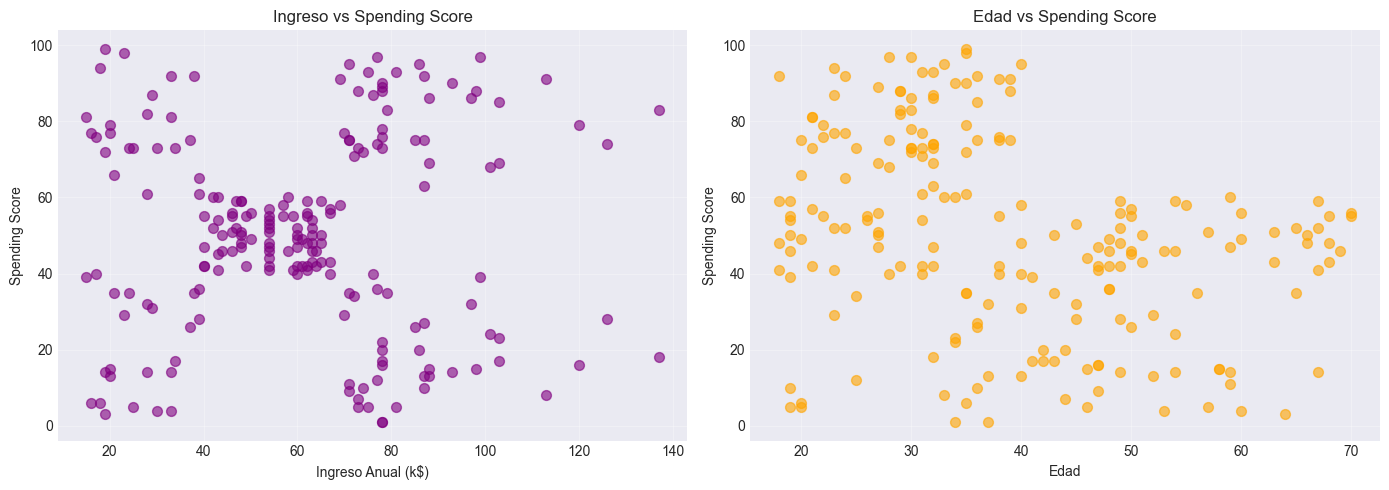

In [7]:
# Relaciones entre variables
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], 
                alpha=0.6, s=50, c='purple')
axes[0].set_xlabel('Ingreso Anual (k$)')
axes[0].set_ylabel('Spending Score')
axes[0].set_title('Ingreso vs Spending Score')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df['Age'], df['Spending Score (1-100)'], 
                alpha=0.6, s=50, c='orange')
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('Spending Score')
axes[1].set_title('Edad vs Spending Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Preparación de Datos

In [8]:
# Seleccionar features numéricas para clustering
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features].copy()

print("Shape de los datos:", X.shape)
print("\nPrimeras filas de features:")
display(X.head())

Shape de los datos: (200, 3)

Primeras filas de features:


,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


Es importante normalizar porque las variables están en diferentes escalas.

In [9]:
# Normalizar con StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir a DataFrame para mejor visualización
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

print("Datos después de normalización:")
display(X_scaled_df.describe())

Datos después de normalización:


,Age,Annual Income (k$),Spending Score (1-100)
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


## 4. Aplicación de K-Means
Probamos diferentes valores de k para encontrar el número óptimo de clusters.

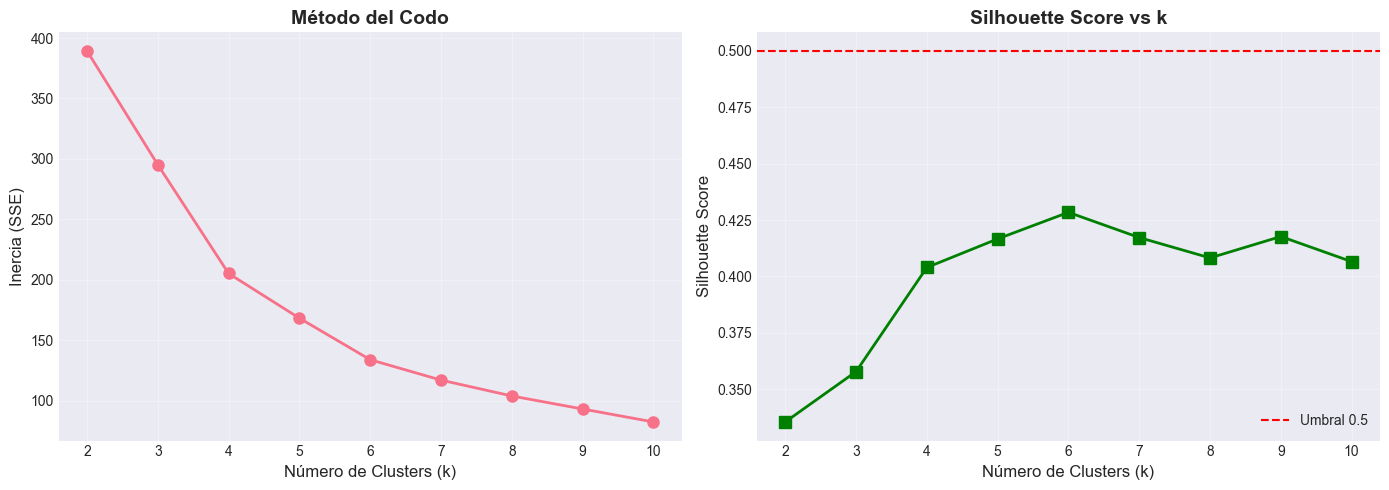


Resultados por valor de k:


,k,Inercia,Silhouette Score
0,2,389.386189,0.335472
1,3,295.212246,0.357793
2,4,205.225147,0.403958
3,5,168.247580,0.416643
4,6,133.868421,0.428417
5,7,117.011555,0.417232
6,8,103.873292,0.408207
7,9,93.092891,0.417693
8,10,82.385154,0.406554


In [10]:
# Método del Codo (Elbow Method)
# Probamos diferentes valores de k para encontrar el número óptimo de clusters.


# Probar diferentes valores de k
k_values = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualizar método del codo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_values, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inercia (SSE)', fontsize=12)
axes[0].set_title('Método del Codo', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_values, silhouette_scores, marker='s', linewidth=2, 
             markersize=8, color='green')
axes[1].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs k', fontsize=14, fontweight='bold')
axes[1].axhline(y=0.5, color='r', linestyle='--', label='Umbral 0.5')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar valores
print("\nResultados por valor de k:")
results_df = pd.DataFrame({
    'k': k_values,
    'Inercia': inertias,
    'Silhouette Score': silhouette_scores
})
display(results_df)

In [11]:
# Selección del k Óptimo y Entrenamiento Final

# Basándonos en el análisis, seleccionamos k óptimo. Típicamente será 4 o 5 para este dataset
optimal_k = 5

print(f"K óptimo seleccionado: {optimal_k}")

# Entrenar modelo final
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Agregar clusters al dataframe original
df['Cluster'] = clusters

# Métricas del modelo final
final_silhouette = silhouette_score(X_scaled, clusters)
print(f"\nSilhouette Score del modelo final: {final_silhouette:.3f}")
print(f"Inercia del modelo final: {kmeans_final.inertia_:.2f}")

# Distribución de clusters
print("\nDistribución de clientes por cluster:")
print(df['Cluster'].value_counts().sort_index())

K óptimo seleccionado: 5

Silhouette Score del modelo final: 0.417
Inercia del modelo final: 168.25

Distribución de clientes por cluster:
Cluster
0    20
1    54
2    40
3    39
4    47
Name: count, dtype: int64


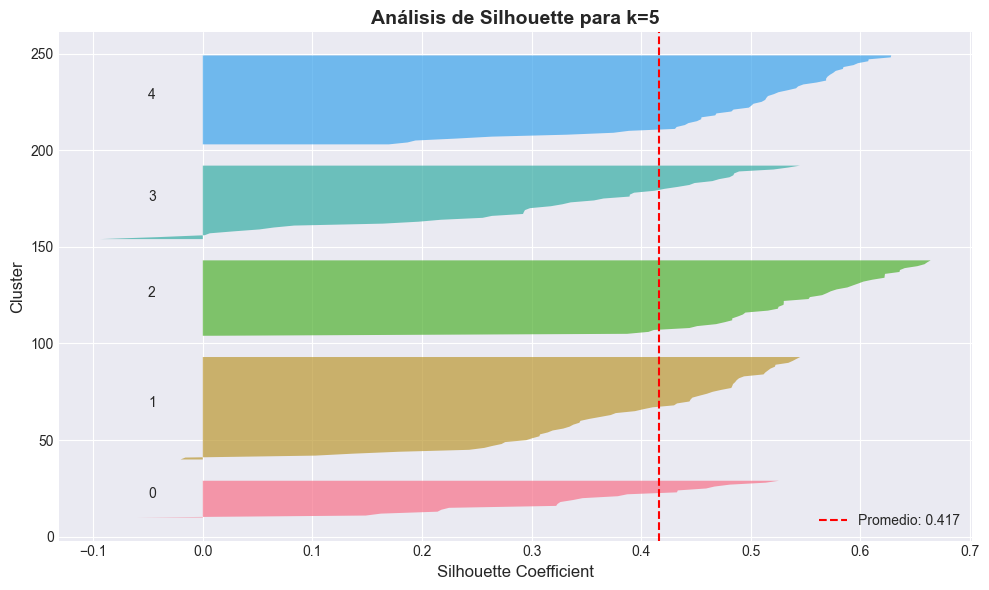

In [12]:
# Análisis de Silhouette por Cluster

# Calcular silhouette samples para cada punto
silhouette_vals = silhouette_samples(X_scaled, clusters)

# Gráfico de silhouette
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title(f'Análisis de Silhouette para k={optimal_k}', fontsize=14, fontweight='bold')
ax.axvline(x=final_silhouette, color='red', linestyle='--', 
           label=f'Promedio: {final_silhouette:.3f}')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Interpretación de Clusters

=== PERFIL DE CADA CLUSTER ===


,Age,Annual Income (k$),Spending Score (1-100),Count
Cluster,,,,
0,46.25,26.75,18.35,20
1,25.19,41.09,62.24,54
2,32.88,86.10,81.53,40
3,39.87,86.10,19.36,39
4,55.64,54.38,48.85,47


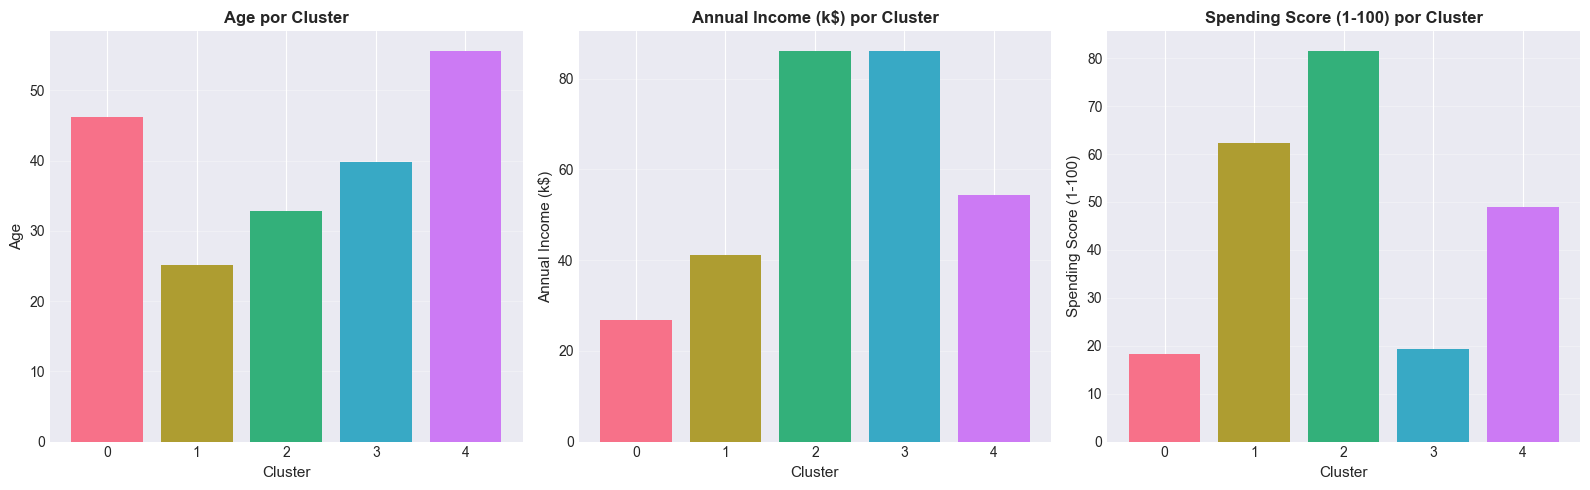

In [13]:
# Estadísticas por cluster
cluster_analysis = df.groupby('Cluster')[features].mean().round(2)
cluster_analysis['Count'] = df.groupby('Cluster').size()

print("=== PERFIL DE CADA CLUSTER ===")
display(cluster_analysis)

# Visualización de perfiles
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, feature in enumerate(features):
    cluster_means = df.groupby('Cluster')[feature].mean()
    axes[idx].bar(cluster_means.index, cluster_means.values, 
                  color=sns.color_palette('husl', optimal_k))
    axes[idx].set_xlabel('Cluster', fontsize=11)
    axes[idx].set_ylabel(feature, fontsize=11)
    axes[idx].set_title(f'{feature} por Cluster', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Reducción de Dimensionalidad y Visualización

Varianza explicada por cada componente: [0.44266167 0.33308378]
Varianza total explicada: 77.57%


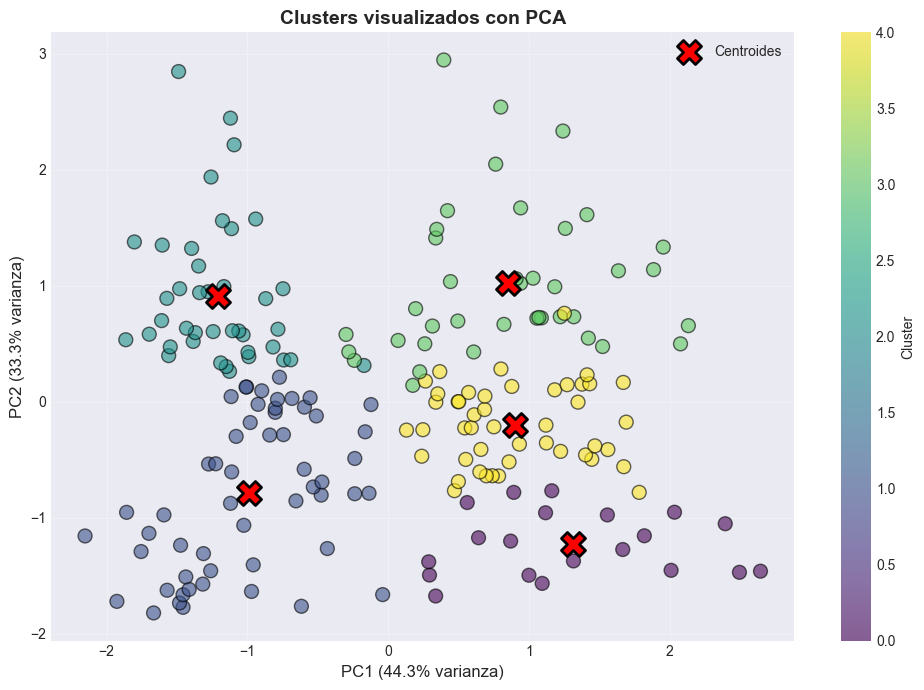

In [14]:
# Visualización con PCA (2D)

# Aplicar PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Agregar componentes al dataframe
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada: {pca.explained_variance_ratio_.sum():.2%}")

# Visualización
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df['PCA1'], df['PCA2'], 
                      c=df['Cluster'], 
                      cmap='viridis', 
                      s=100, 
                      alpha=0.6, 
                      edgecolors='black')

# Agregar centroides
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            c='red', 
            s=300, 
            alpha=1, 
            marker='X',
            edgecolors='black',
            linewidths=2,
            label='Centroides')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)', fontsize=12)
plt.title('Clusters visualizados con PCA', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

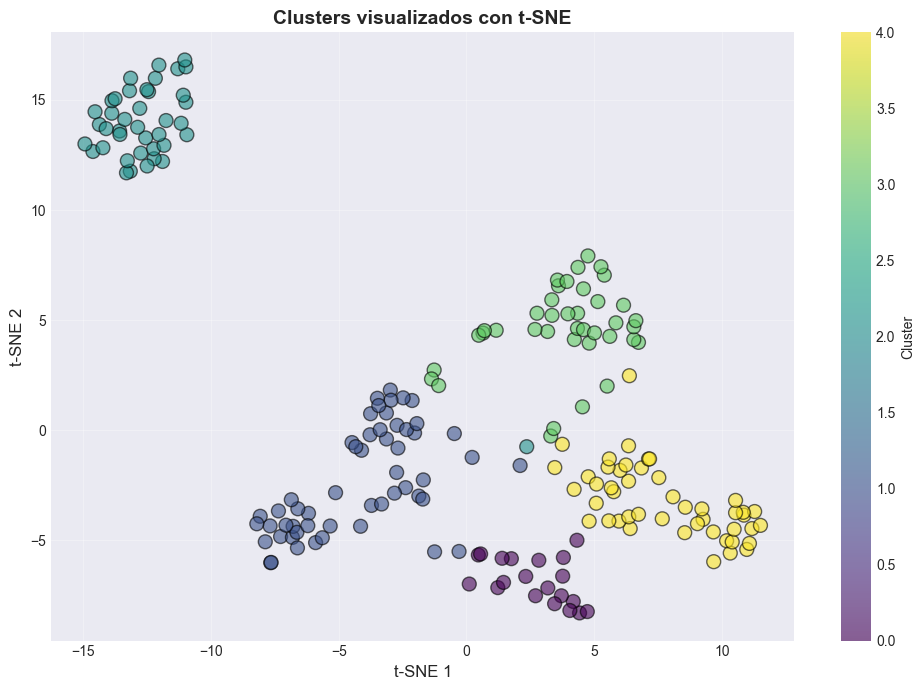

In [15]:
# Visualización con t-SNE (EXTRA CREDIT)

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Agregar al dataframe
df['TSNE1'] = X_tsne[:, 0]
df['TSNE2'] = X_tsne[:, 1]

# Visualización
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df['TSNE1'], df['TSNE2'], 
                      c=df['Cluster'], 
                      cmap='viridis', 
                      s=100, 
                      alpha=0.6, 
                      edgecolors='black')

plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.title('Clusters visualizados con t-SNE', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

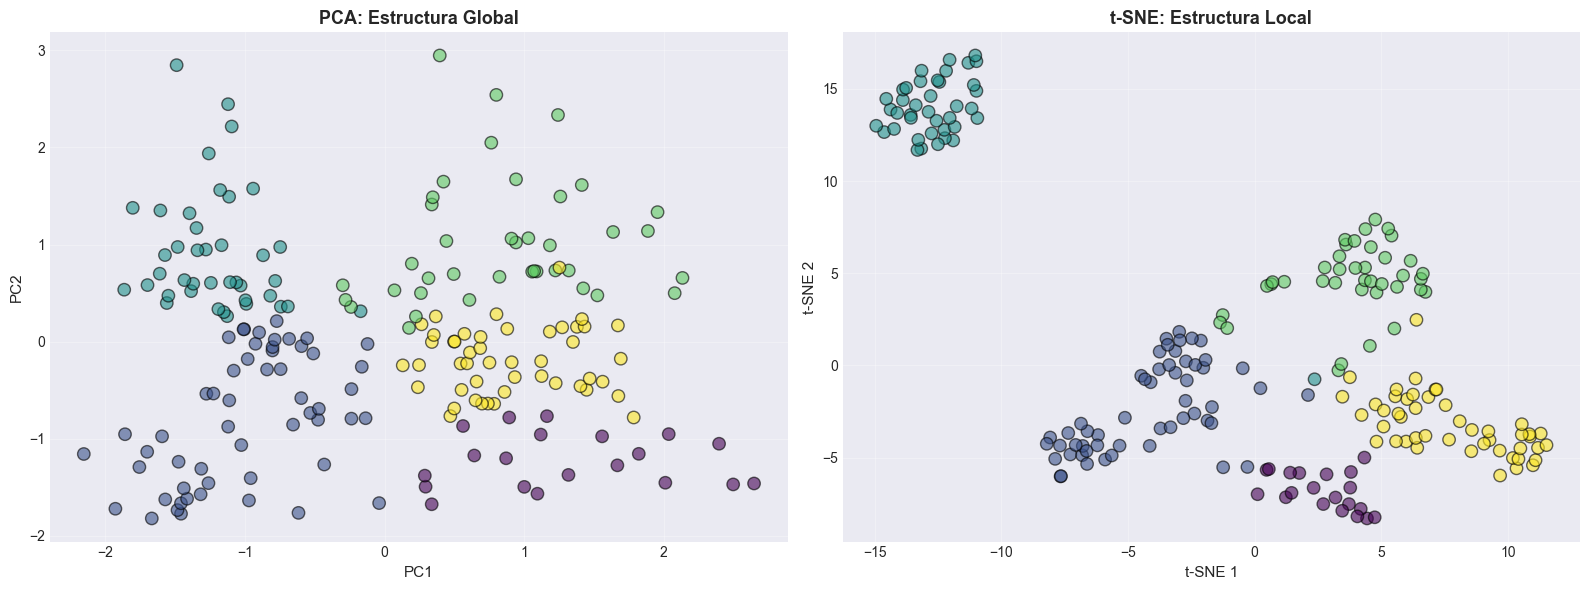

In [16]:
# Comparación PCA vs t-SNE

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA
scatter1 = axes[0].scatter(df['PCA1'], df['PCA2'], 
                           c=df['Cluster'], 
                           cmap='viridis', 
                           s=80, 
                           alpha=0.6, 
                           edgecolors='black')
axes[0].set_xlabel('PC1', fontsize=11)
axes[0].set_ylabel('PC2', fontsize=11)
axes[0].set_title('PCA: Estructura Global', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# t-SNE
scatter2 = axes[1].scatter(df['TSNE1'], df['TSNE2'], 
                           c=df['Cluster'], 
                           cmap='viridis', 
                           s=80, 
                           alpha=0.6, 
                           edgecolors='black')
axes[1].set_xlabel('t-SNE 1', fontsize=11)
axes[1].set_ylabel('t-SNE 2', fontsize=11)
axes[1].set_title('t-SNE: Estructura Local', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Algoritmos Alternativos (EXTRA CREDIT)

Número de clusters encontrados: 6
Puntos de ruido: 60
Silhouette Score (sin ruido): 0.482


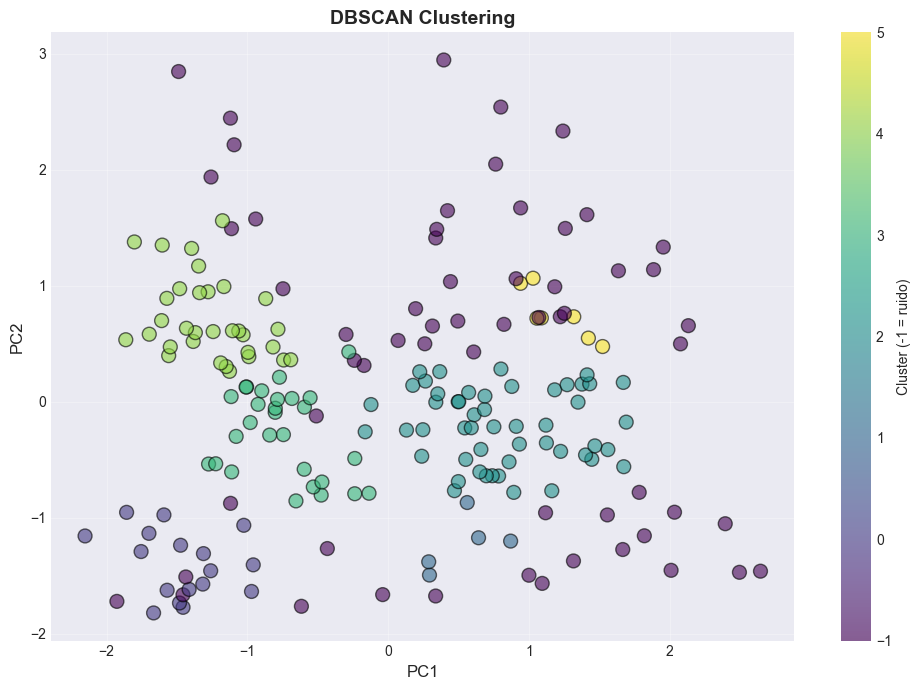

In [17]:
# DBSCAN (Density-Based Clustering)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Agregar etiquetas
df['DBSCAN_Cluster'] = dbscan_labels

# Número de clusters (excluyendo ruido -1)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Número de clusters encontrados: {n_clusters_dbscan}")
print(f"Puntos de ruido: {n_noise}")

if n_clusters_dbscan > 1:
    # Calcular silhouette solo para puntos no-ruido
    mask = dbscan_labels != -1
    if mask.sum() > 0:
        dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        print(f"Silhouette Score (sin ruido): {dbscan_silhouette:.3f}")

# Visualización
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df['PCA1'], df['PCA2'], 
                      c=df['DBSCAN_Cluster'], 
                      cmap='viridis', 
                      s=100, 
                      alpha=0.6, 
                      edgecolors='black')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('DBSCAN Clustering', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster (-1 = ruido)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Silhouette Score (Agglomerative): 0.390


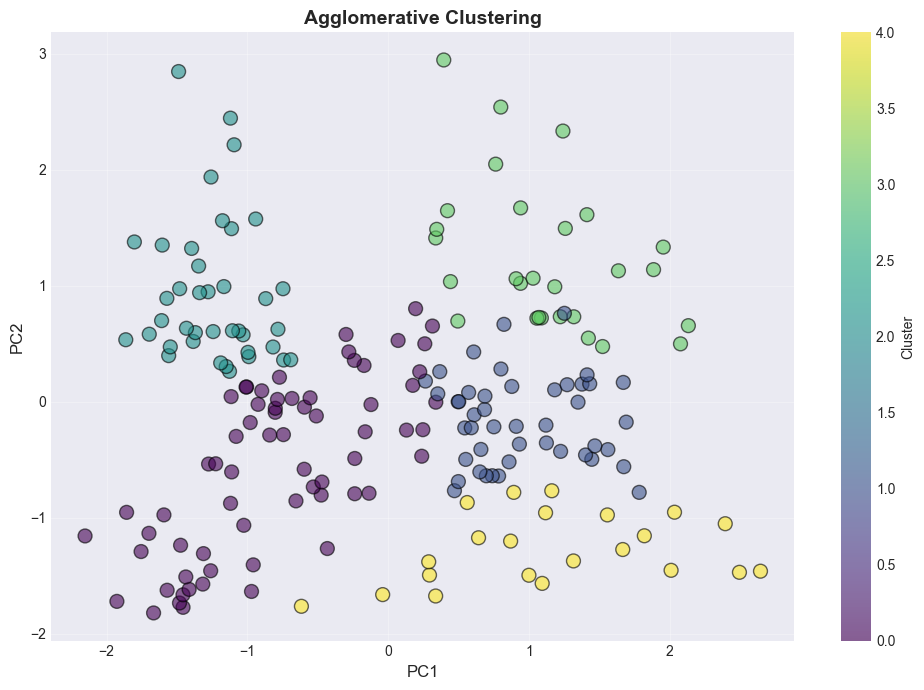

In [18]:
# Agglomerative Clustering (Jerárquico)

# Aplicar clustering jerárquico
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_scaled)

# Agregar etiquetas
df['Agglomerative_Cluster'] = agg_labels

# Métricas
agg_silhouette = silhouette_score(X_scaled, agg_labels)
print(f"Silhouette Score (Agglomerative): {agg_silhouette:.3f}")

# Visualización
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df['PCA1'], df['PCA2'], 
                      c=df['Agglomerative_Cluster'], 
                      cmap='viridis', 
                      s=100, 
                      alpha=0.6, 
                      edgecolors='black')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('Agglomerative Clustering', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

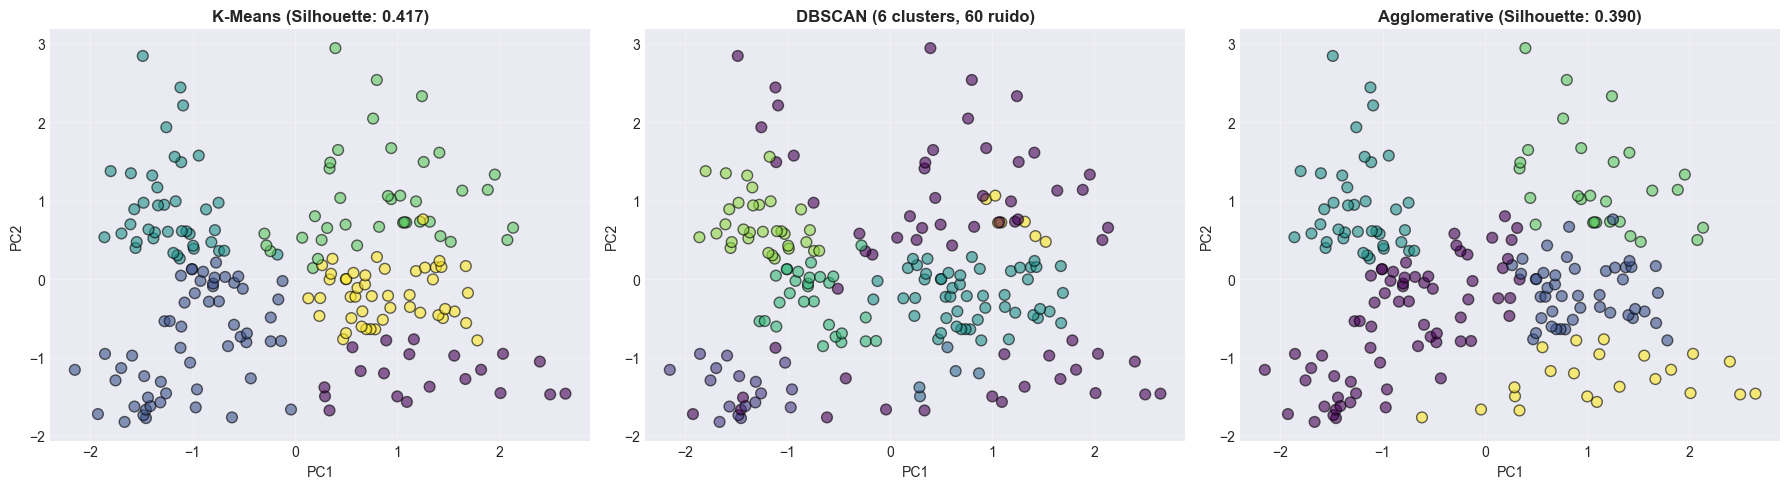


=== COMPARACIÓN DE ALGORITMOS ===


,Algoritmo,N° Clusters,Silhouette Score
0,K-Means,5,0.416643
1,DBSCAN,6,0.481715
2,Agglomerative,5,0.390028


In [19]:
# Comparación de Algoritmos

# Comparación visual de los tres algoritmos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-Means
axes[0].scatter(df['PCA1'], df['PCA2'], c=df['Cluster'], 
                cmap='viridis', s=60, alpha=0.6, edgecolors='black')
axes[0].set_title(f'K-Means (Silhouette: {final_silhouette:.3f})', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(True, alpha=0.3)

# DBSCAN
axes[1].scatter(df['PCA1'], df['PCA2'], c=df['DBSCAN_Cluster'], 
                cmap='viridis', s=60, alpha=0.6, edgecolors='black')
axes[1].set_title(f'DBSCAN ({n_clusters_dbscan} clusters, {n_noise} ruido)', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(True, alpha=0.3)

# Agglomerative
axes[2].scatter(df['PCA1'], df['PCA2'], c=df['Agglomerative_Cluster'], 
                cmap='viridis', s=60, alpha=0.6, edgecolors='black')
axes[2].set_title(f'Agglomerative (Silhouette: {agg_silhouette:.3f})', 
                  fontsize=12, fontweight='bold')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla comparativa
print("\n=== COMPARACIÓN DE ALGORITMOS ===")
comparison = pd.DataFrame({
    'Algoritmo': ['K-Means', 'DBSCAN', 'Agglomerative'],
    'N° Clusters': [optimal_k, n_clusters_dbscan, optimal_k],
    'Silhouette Score': [final_silhouette, 
                         dbscan_silhouette if n_clusters_dbscan > 1 else 'N/A', 
                         agg_silhouette]
})
display(comparison)

## 8. Etiquetas Interpretativas (EXTRA CREDIT)

=== DISTRIBUCIÓN DE ETIQUETAS ===
Customer_Label
Average Customer        82
High Value Customer     37
Conservative Spender    36
Aspirational Buyer      23
Low Engagement          22
Name: count, dtype: int64


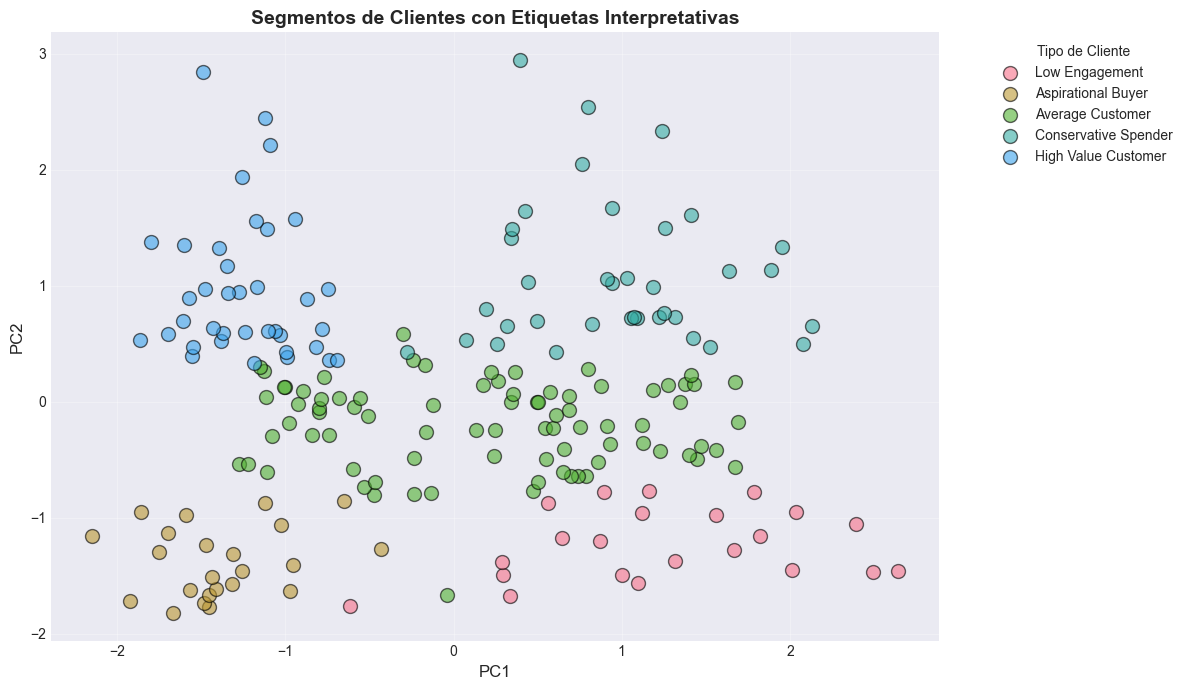

In [20]:
# Función para asignar etiquetas interpretativas basadas en las características
def assign_cluster_label(row):
    cluster = row['Cluster']
    age = row['Age']
    income = row['Annual Income (k$)']
    spending = row['Spending Score (1-100)']
    
    # Lógica basada en los perfiles encontrados
    
    if income > 70 and spending > 60:
        return 'High Value Customer'
    elif income < 40 and spending < 40:
        return 'Low Engagement'
    elif spending > 60 and income < 50:
        return 'Aspirational Buyer'
    elif income > 70 and spending < 40:
        return 'Conservative Spender'
    else:
        return 'Average Customer'

# Aplicar etiquetas
df['Customer_Label'] = df.apply(assign_cluster_label, axis=1)

# Mostrar distribución
print("=== DISTRIBUCIÓN DE ETIQUETAS ===")
print(df['Customer_Label'].value_counts())

# Visualización con etiquetas
plt.figure(figsize=(12, 7))

for label in df['Customer_Label'].unique():
    mask = df['Customer_Label'] == label
    plt.scatter(df[mask]['PCA1'], df[mask]['PCA2'], 
                label=label, s=100, alpha=0.6, edgecolors='black')

plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('Segmentos de Clientes con Etiquetas Interpretativas', 
          fontsize=14, fontweight='bold')
plt.legend(title='Tipo de Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Interpretación Final de Clusters
Basándonos en el análisis realizado, podemos caracterizar cada cluster:

In [21]:
# Crear resumen detallado por cluster
print("=== PERFIL DETALLADO POR CLUSTER ===")


for cluster_id in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster_id]
    
    print(f"\nCLUSTER {cluster_id}:")
    print(f"  Tamaño: {len(cluster_data)} clientes ({len(cluster_data)/len(df)*100:.1f}%)")
    print(f"  Edad promedio: {cluster_data['Age'].mean():.1f} años")
    print(f"  Ingreso promedio: ${cluster_data['Annual Income (k$)'].mean():.1f}k")
    print(f"  Spending Score promedio: {cluster_data['Spending Score (1-100)'].mean():.1f}/100")
    print(f"  Género predominante: {cluster_data['Gender'].mode()[0]}")


=== PERFIL DETALLADO POR CLUSTER ===

CLUSTER 0:
  Tamaño: 20 clientes (10.0%)
  Edad promedio: 46.2 años
  Ingreso promedio: $26.8k
  Spending Score promedio: 18.4/100
  Género predominante: Female

CLUSTER 1:
  Tamaño: 54 clientes (27.0%)
  Edad promedio: 25.2 años
  Ingreso promedio: $41.1k
  Spending Score promedio: 62.2/100
  Género predominante: Female

CLUSTER 2:
  Tamaño: 40 clientes (20.0%)
  Edad promedio: 32.9 años
  Ingreso promedio: $86.1k
  Spending Score promedio: 81.5/100
  Género predominante: Female

CLUSTER 3:
  Tamaño: 39 clientes (19.5%)
  Edad promedio: 39.9 años
  Ingreso promedio: $86.1k
  Spending Score promedio: 19.4/100
  Género predominante: Male

CLUSTER 4:
  Tamaño: 47 clientes (23.5%)
  Edad promedio: 55.6 años
  Ingreso promedio: $54.4k
  Spending Score promedio: 48.9/100
  Género predominante: Female


### Interpretación sugerida:

- **Cluster 0 - "Low Engagement Seniors"**: Clientes de mediana edad (46 años) con bajo ingreso ($27k) y muy bajo spending score (18/100). Son el 10% de la base. Este grupo tiene baja capacidad de compra y poca propensión al gasto. Requieren estrategias de engagement básico y productos económicos.

- **Cluster 1 - "Young Enthusiasts"**: Clientes jóvenes (25 años) con ingreso medio ($41k) pero alto spending score (62/100). Representan el 27% de la base. A pesar de ingresos moderados, tienen alta propensión a gastar. Son el target ideal para productos en tendencia, marketing digital y programas de fidelización.

- **Cluster 2 - "High Value Customers"**: Clientes de edad media (33 años) con alto ingreso ($86k) y muy alto spending score (82/100). Son el 20% de la base y el segmento premium. Generan el mayor revenue. Estrategia: productos exclusivos, servicios premium, early access.

- **Cluster 3 - "Conservative High-Income"**: Clientes maduros (40 años) con alto ingreso ($86k) pero bajo spending score (19/100). Son el 19.5% de la base, predominantemente masculino. Tienen capacidad económica pero son cautelosos. Requieren estrategias de activación: ofertas personalizadas, productos de alta calidad-precio, justificación de valor.

- **Cluster 4 - "Mature Average"**: Clientes mayores (56 años) con ingreso medio ($54k) y spending score medio (49/100). Representan el 23.5% de la base. Segmento estable y predecible. Estrategia: productos clásicos, servicio al cliente de calidad, comunicación tradicional.


## 10. Reflexión sobre Sistemas de Recomendación (Extra Credit)

Los clusters obtenidos pueden servir como base para un sistema de recomendación tipo "usuarios similares":

- **Recomendación por cluster**: Si un cliente del Cluster 2 (High Value) compra un producto X, ese producto puede recomendarse a otros clientes del mismo cluster, ya que comparten patrones similares de edad, ingreso y propensión al gasto.

- **Cold-start problem**: Para nuevos clientes sin historial de compras, podemos asignarlos inmediatamente a un cluster según sus datos demográficos y recomendar productos populares de ese segmento.

- **Eficiencia**: Reduce la complejidad computacional al buscar similitudes solo dentro del cluster en lugar de comparar con toda la base de clientes.

Este enfoque de clustering funciona como un **primer filtro** que puede combinarse con técnicas más avanzadas de collaborative filtering para mejorar la precisión de las recomendaciones.

## 11. Exportar Resultados

In [ ]:
# Guardar dataset con clusters
df_export = df[['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 
                'Spending Score (1-100)', 'Cluster']].copy()

df_export.to_csv('../data/customers_with_clusters.csv', index=False)
print("Resultados exportados a 'customers_with_clusters.csv'")

# Resumen final
print("RESUMEN DEL ANÁLISIS")

print(f"Total de clientes analizados: {len(df)}")
print(f"Número óptimo de clusters: {optimal_k}")
print(f"Silhouette Score: {final_silhouette:.3f}")
print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_.sum():.2%}")

Resultados exportados a 'customers_with_clusters.csv'
RESUMEN DEL ANÁLISIS
Total de clientes analizados: 200
Número óptimo de clusters: 5
Silhouette Score: 0.417
Varianza explicada por PCA: 77.57%


## Conclusiones

Este análisis ha permitido segmentar 200 clientes en 5 grupos con comportamientos distintos, validar la calidad del clustering mediante múltiples métricas, y generar insights accionables para estrategias de negocio y sistemas de recomendación.

**Clusters identificados:** Low Engagement Seniors (10%), Young Enthusiasts (27%), High Value Customers (20%), Conservative High-Income (19.5%), y Mature Average (23.5%).